# Features

Here we will go through the different features that we can compute with `ap_features`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ap_features as apf

## Single beat features

To start with we will go through some features that we can derive from a single beat. To illustrate this we will use a synthetic calcium transient

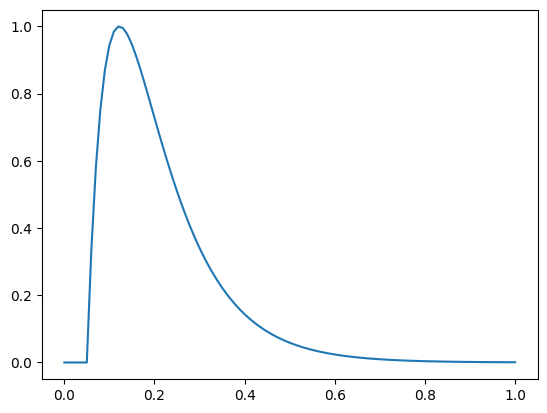

In [8]:
time = np.linspace(0, 1, 101)
tstart = 0.05
y = apf.testing.ca_transient(t=time, tstart=tstart)

fig, ax = plt.subplots()
ax.plot(time, y)
plt.show()

Notice that the trace starts at `t=0.05` and we could use a pacing amplitude to indicate this, e.g

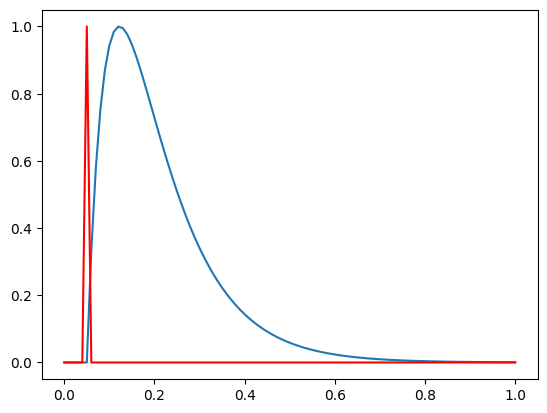

In [11]:
pacing = np.zeros_like(time)
pacing[np.isclose(time, tstart)]  = 1

fig, ax = plt.subplots()
ax.plot(time, y)
ax.plot(time, pacing, color="red")
plt.show()

Another way to work with `ap_feautres` is to convert the trace into a beat, in which case you can do

(<Figure size 640x480 with 2 Axes>, <AxesSubplot: xlabel='Time (ms)'>)

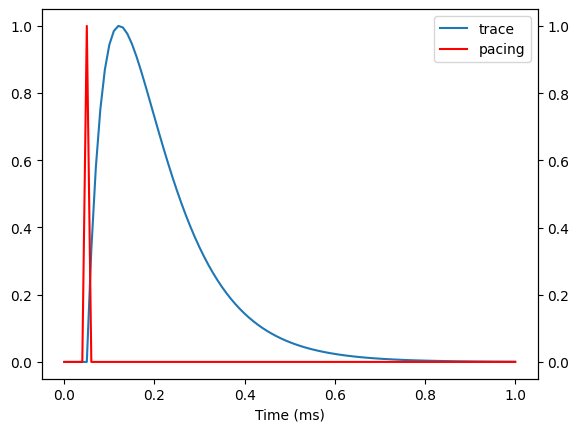

In [66]:
beat = apf.Beat(y=y, t=time, pacing=pacing)

beat.plot(include_pacing=True)

In [45]:
def arrow_annotate(ax, y1, y2, t1, t2, label, add_bbox=False):
    mid_t = 0.5 * (t1 + t2)
    mid_y = 0.5 * (y1 + y2)
    ax.annotate(
        text="",
        xy=(t1, y1),
        xytext=(t2, y2),
        arrowprops=dict(arrowstyle="<->"),
    )
    ax.text(
        mid_t,
        mid_y,
        label,
        size="large",
        bbox=dict(boxstyle="circle", fc="w", ec="k") if add_bbox else None,
    )

### Time to peak

Time to peak is the time to the maximum attained value of the trace

If no more information than the time stamps and the trace is available, the algorithm will compute the time from the first time stamp (here 0.0) to the time of the maximum attained value

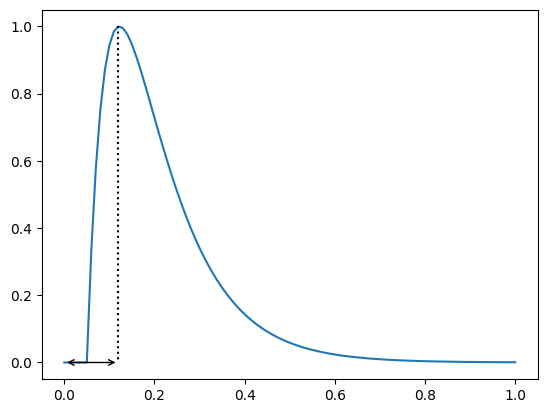

In [52]:
idx_max = np.argmax(y)
t_max = time[idx_max]
y_max = y[idx_max]
y_start = 0.0

fig, ax = plt.subplots()
ax.plot(time, y)
ax.plot([t_max, t_max],[y_max, y_start], "k:")
arrow_annotate(ax=ax, y1=0.0, y2=0.0, t1=0.0, t2=t_max, label="")
plt.show()

In this case we have

In [14]:
print(apf.features.time_to_peak(y=y, x=time))

0.12


However, if we have pacing information available we can extract information about when the upstroke starts

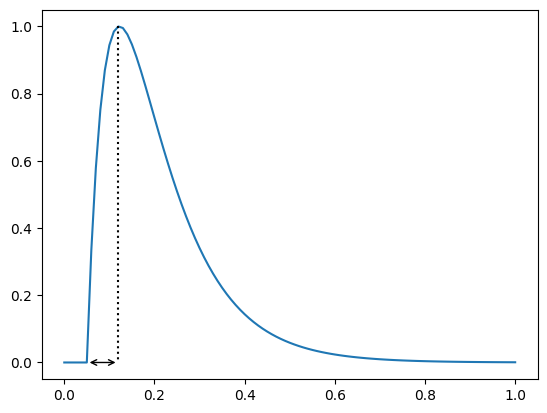

In [23]:
fig, ax = plt.subplots()
ax.plot(time, y)
ax.plot([t_max, t_max],[y_max, y_start], "k:")
arrow_annotate(ax=ax, y1=0.0, y2=0.0, t1=tstart, t2=t_max, label="")

In which case we have for this trace

In [15]:
print(apf.features.time_to_peak(y=y, x=time, pacing=pacing))

0.06999999999999999


or using the `beat` object

In [67]:
beat.ttp(use_pacing=True)

0.06999999999999999

### Action potential duration (APD)

To compute the action potential duration, commonly abbreviated as APD, you first need to find the points when your trace intersects with the APD$p$ - line and then compute the time difference between those two intersections. For example, say if you want to compute APD30, then you need to find the two intersecting points of the APD30-line which is where you are 30% from the peak of the trace. Once you have found those two intersections you can compute the time difference between those two points. 

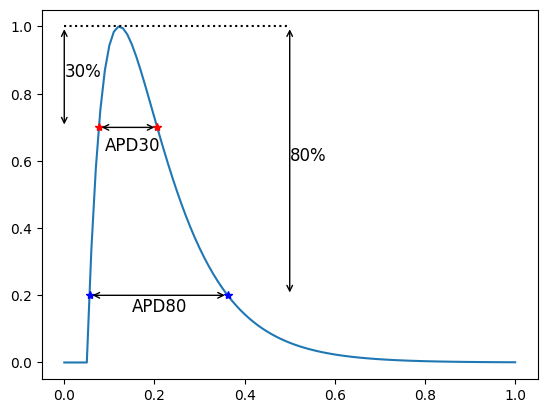

In [49]:
apd_coords30 = apf.features.apd_coords(30, V=y, t=time)
apd_coords80 = apf.features.apd_coords(80, V=y, t=time)


fig, ax = plt.subplots()
ax.plot(time, y)
ax.plot([apd_coords30.x1], [apd_coords30.y1], "r*")
ax.plot([apd_coords30.x2], [apd_coords30.y2], "r*")
ax.plot([apd_coords80.x1], [apd_coords80.y1], "b*")
ax.plot([apd_coords80.x2], [apd_coords80.y2], "b*")
ax.plot([0.0, 0.5], [1, 1], "k:")
arrow_annotate(
    ax=ax, 
    y1=apd_coords30.y1, 
    y2=apd_coords30.y2, 
    t1=apd_coords30.x1,
    t2=apd_coords30.x2, 
    label=""
)
arrow_annotate(
    ax=ax, 
    y1=apd_coords80.y1, 
    y2=apd_coords80.y2, 
    t1=apd_coords80.x1,
    t2=apd_coords80.x2, 
    label=""
)
ax.text(
    0.09,
    0.63,
    "APD30",
    size="large",
)
ax.text(
    0.15,
    0.15,
    "APD80",
    size="large",
)
arrow_annotate(ax=ax, y1=1.0, y2=0.7, t1=0.0, t2=0.0, label="30%")
arrow_annotate(ax=ax, y1=1.0, y2=0.2, t1=0.5, t2=0.5, label="80%")

Here we show the APD30 and APD80 which in this case is

In [82]:
print(f"ADP30 = {apf.features.apd(0.3, y, time)}")
print(f"ADP80 = {apf.features.apd(0.8, y, time)}")

ADP30 = 0.12940912122129322
ADP80 = 0.3059229823735669


or using the `beat` object

In [81]:
print(f"ADP30 = {beat.apd(0.3)}")
print(f"ADP80 = {beat.apd(0.8)}")

ADP30 = 0.12940912122129322
ADP80 = 0.3059229823735669


### Decay time ($\tau$)

The decay time, also referred to as $\tau_p$ (for some $p$) is the time from the attained peak value to the intersection of the APD $p$-line occurring after the peak value (i.e during the repolarization)

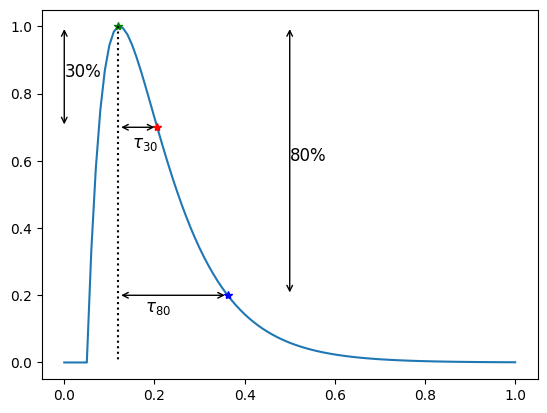

In [63]:
idx_max = np.argmax(y)
t_max = time[idx_max]
y_max = y[idx_max]
y_start = 0.0

apd_coords30 = apf.features.apd_coords(30, V=y, t=time)
apd_coords80 = apf.features.apd_coords(80, V=y, t=time)


fig, ax = plt.subplots()
ax.plot(time, y)
ax.plot([t_max], [y_max], "g*")
ax.plot([apd_coords30.x2], [apd_coords30.y2], "r*")
ax.plot([apd_coords80.x2], [apd_coords80.y2], "b*")
ax.plot([t_max, t_max], [y_max, 0], "k:")
arrow_annotate(
    ax=ax, 
    y1=apd_coords30.y1, 
    y2=apd_coords30.y2, 
    t1=t_max,
    t2=apd_coords30.x2, 
    label=""
)
arrow_annotate(
    ax=ax, 
    y1=apd_coords80.y1, 
    y2=apd_coords80.y2, 
    t1=t_max,
    t2=apd_coords80.x2, 
    label=""
)
ax.text(
    0.15,
    0.64,
    r"$\tau_{30}$",
    size="large",
)
ax.text(
    0.18,
    0.15,
    r"$\tau_{80}$",
    size="large",
)
arrow_annotate(ax=ax, y1=1.0, y2=0.7, t1=0.0, t2=0.0, label="30%")
arrow_annotate(ax=ax, y1=1.0, y2=0.2, t1=0.5, t2=0.5, label="80%")

Here you see the $\tau_{30}$ and $\tau_{80}$ which in this case is

In [86]:
print(f"\u03C4_30 = {apf.features.tau(a=0.3, y=y, x=time)}")
print(f"\u03C4_80 = {apf.features.tau(a=0.8, y=y, x=time)}")

τ_30 = 0.1951680427731784
τ_80 = 0.06484277207692196


or using the `beat` object

In [79]:
print(f"\u03C4_30 = {beat.tau(0.3)}")
print(f"\u03C4_80 = {beat.tau(0.8)}")

τ_30 = 0.1951680427731784
τ_80 = 0.06484277207692196


### Upstroke time

The upstroke time is the time from the first intersection of the APD $p$-line occurring before the peak value (i.e during the depolarization) to the attained peak value

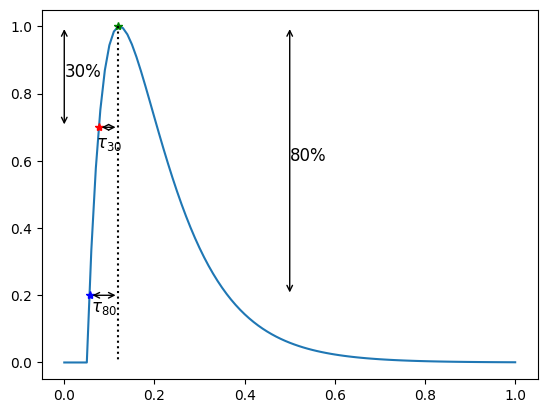

In [93]:
idx_max = np.argmax(y)
t_max = time[idx_max]
y_max = y[idx_max]
y_start = 0.0

apd_coords30 = apf.features.apd_coords(30, V=y, t=time)
apd_coords80 = apf.features.apd_coords(80, V=y, t=time)


fig, ax = plt.subplots()
ax.plot(time, y)
ax.plot([t_max], [y_max], "g*")
ax.plot([apd_coords30.x1], [apd_coords30.y1], "r*")
ax.plot([apd_coords80.x1], [apd_coords80.y1], "b*")
ax.plot([t_max, t_max], [y_max, 0], "k:")
arrow_annotate(
    ax=ax, 
    y1=apd_coords30.y1, 
    y2=apd_coords30.y2, 
    t1=t_max,
    t2=apd_coords30.x1, 
    label=""
)
arrow_annotate(
    ax=ax, 
    y1=apd_coords80.y1, 
    y2=apd_coords80.y2, 
    t1=t_max,
    t2=apd_coords80.x1, 
    label=""
)
ax.text(
    0.07,
    0.64,
    r"$\tau_{30}$",
    size="large",
)
ax.text(
    0.06,
    0.15,
    r"$\tau_{80}$",
    size="large",
)
arrow_annotate(ax=ax, y1=1.0, y2=0.7, t1=0.0, t2=0.0, label="30%")
arrow_annotate(ax=ax, y1=1.0, y2=0.2, t1=0.5, t2=0.5, label="80%")